In [86]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [87]:
# Load CSV
file_path = '../data/psd_features_csv/all.csv'
df = pd.read_csv(file_path)
df.head()

,mean_Delta,mean_Theta,mean_Alpha,mean_Beta,mean_Gamma,mean_Slow,mean_Low_beta,Fp1_Delta,Fp1_Theta,Fp1_Alpha,...,O2_Slow,O2_Low_beta,alpha_frontal,alpha_temporal,alpha_asymmetry,beta_frontal,beta_temporal,beat_asymmetry,participant_id,label
0,-110.329965,-121.299482,-123.725032,-131.335399,-134.971232,-123.031043,-128.526178,-106.209371,-117.231013,-122.637565,...,-122.325200,-127.567021,-0.002908,-0.000649,-0.003557,-0.002668,0.010859,0.008191,1,1
1,-110.383640,-121.158052,-123.636121,-130.643007,-134.449370,-123.097757,-128.670923,-107.994728,-120.509328,-120.470155,...,-123.572993,-130.006559,-0.005629,-0.008944,-0.014573,-0.001315,0.003450,0.002135,1,1
2,-111.593383,-120.712248,-124.276396,-130.440765,-134.357490,-123.286220,-130.602665,-110.782820,-117.801016,-121.948612,...,-123.730226,-131.785838,-0.003908,-0.004460,-0.008369,0.000354,0.002001,0.002355,1,1
3,-111.292704,-122.189083,-123.512155,-128.614875,-135.116331,-123.276588,-127.691734,-108.605531,-119.022817,-119.382605,...,-125.327886,-129.835990,-0.005010,0.010191,0.005181,-0.005576,0.003535,-0.002042,1,1
4,-113.361314,-119.989890,-123.255042,-130.600926,-135.144714,-122.298936,-129.782153,-109.577307,-117.077183,-119.433042,...,-122.141809,-131.338841,0.001069,-0.002919,-0.001850,-0.007245,0.008795,0.001550,1,1


In [88]:
# Check for imbalance
df['label'].value_counts()

0    240
1    168
Name: label, dtype: int64

In [89]:
# Select equal number of samples from each label
label_1 = df.loc[df['label'] == 1]
label_1.shape

(168, 127)

In [90]:
label_0 = df.loc[df['label'] == 0].sample(n=label_1.shape[0], random_state=999)
label_0.shape

(168, 127)

In [91]:
new_df = pd.concat([label_1, label_0])
new_df['label'].value_counts()

1    168
0    168
Name: label, dtype: int64

In [92]:
# Feature selection/extraction
X = new_df[['mean_Delta', 'mean_Theta', 'mean_Alpha', 'mean_Beta', 'mean_Gamma', 'alpha_frontal', 'alpha_temporal', 'beta_frontal', 'beta_temporal']]
y = new_df[['label']]

In [93]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 999
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((268, 9), (68, 9), (268, 1), (68, 1))

In [94]:
# Convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1)
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((268, 9), (68, 9), (268,), (68,))

In [95]:
X_train[1,:]

array([-1.08456727e+02, -1.16925839e+02, -1.18330785e+02, -1.21740811e+02,
       -1.21704059e+02,  1.97421536e-02,  8.61824271e-03, -6.85663652e-04,
        2.21666536e-03])

In [96]:
# Scaling X features
# Note each feature is scaled independently

X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_minmax = scalers[i].fit_transform(X_train[:,i].reshape(-1, 1))
    X_train_scaled[:,i] = X_minmax[:,0]

# for i in range(X_val.shape[1]):
#     X_val[:, i, :]   = scalers[i].transform(X_val[:, i, :])     
    
for i in range(X_test.shape[1]):
    X_test_minmax = scalers[i].transform(X_test[:,i].reshape(-1, 1))
    X_test_scaled[:,i] = X_test_minmax[:,0]

(268, 9) (68, 9)


In [97]:
X_train[1,:], X_test[1,:]

(array([-1.08456727e+02, -1.16925839e+02, -1.18330785e+02, -1.21740811e+02,
        -1.21704059e+02,  1.97421536e-02,  8.61824271e-03, -6.85663652e-04,
         2.21666536e-03]),
 array([-1.05584829e+02, -1.11148734e+02, -1.11882610e+02, -1.13157015e+02,
        -1.15305458e+02, -2.48964453e-03,  2.29470837e-04, -2.55549932e-03,
         6.36609111e-04]))

In [98]:
X_train_scaled[1,:], X_test_scaled[1,:]

(array([-0.45958387, -0.51645435, -0.29969792, -0.33463017, -0.24182706,
        -0.24740442,  0.80143595, -0.47593974,  0.78066643]),
 array([-0.14314143,  0.02390085,  0.29069923,  0.25750161,  0.1140466 ,
        -0.54291136,  0.75005363, -0.51737282,  0.77187536]))

In [99]:
# Grid serach

# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf', 'sigmoid']} 
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['sigmoid']} 

estimator = SVC(max_iter=10000)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=999)
    
grid = GridSearchCV(estimator, 
                    param_grid, 
                    cv=cv,
                    refit = True, 
                    verbose = 0)
  
# Fitting the model for grid search
grid.fit(X_train_scaled, y_train)

/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: Convergence

/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/anjana/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: Convergence

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=999, test_size=0.2,
            train_size=None),
             estimator=SVC(max_iter=10000),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [100]:
# print best parameter after tuning
print(grid.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [101]:
print(grid.best_estimator_)

SVC(C=1, gamma=1, max_iter=10000)


In [102]:
yhat = grid.predict(X_test_scaled)
accuracy_score(y_test, yhat)

0.9264705882352942

In [103]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        34
           1       0.97      0.88      0.92        34

    accuracy                           0.93        68
   macro avg       0.93      0.93      0.93        68
weighted avg       0.93      0.93      0.93        68



In [104]:
#{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
final_svm = SVC(random_state=999, C=1, gamma=1, kernel='rbf', max_iter=10000)
final_svm.fit(X_train_scaled, y_train)

SVC(C=1, gamma=1, max_iter=10000, random_state=999)

In [105]:
yhat = final_svm.predict(X_test_scaled)
accuracy_score(y_test, yhat)

0.9264705882352942

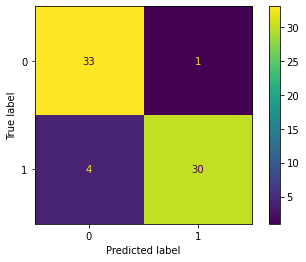

In [106]:
cm = confusion_matrix(y_test, yhat, labels=final_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=final_svm.classes_)
disp.plot()

plt.show()